# increasing number of genes to show increasing classification accuracy


In [ ]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
from scprint2.tasks import Embedder

from scipy.stats import spearmanr
from anndata import AnnData

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [ ]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/temp/"  # "../../data/temp/"  #

## prepare the data


In [1]:
adata = sc.read(
    LOC + "glio_smart_cort_area" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/a1d40c84-c81c-406f-bef4-e25edeb651e5.h5ad",
)
# adata = sc.read(
#    LOC + "glio_smart_highdepth" + ".h5ad",
#    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
# )

In [3]:
(adata.X > 0).sum(1).mean()

7376.551793917073

In [29]:
adata.X.data[:10]

array([ 41.,  36.,   1., 639.,   1.,   5.,   9., 149.,  17., 149.],
      dtype=float32)

In [ ]:
adata.obs.cell_type.value_counts()

cell_type
glutamatergic neuron                                              21841
L2/3-6 intratelencephalic projecting glutamatergic neuron          4778
VIP GABAergic cortical interneuron                                 3533
pvalb GABAergic cortical interneuron                               2800
L6 corticothalamic-projecting glutamatergic cortical neuron        2556
lamp5 GABAergic cortical interneuron                               2434
sst GABAergic cortical interneuron                                 2358
unknown                                                            1985
oligodendrocyte                                                    1930
astrocyte                                                          1187
L6b glutamatergic cortical neuron                                  1080
near-projecting glutamatergic cortical neuron                       816
oligodendrocyte precursor cell                                      773
microglial cell                                       

In [2]:
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=True,
)
print(adata.X.sum(1).mean())
adata = preprocessor(adata)

1353725.5
Dropping layers:  KeysView(Layers with keys: exon, intron)
checking raw counts
removed 0 non primary cells, 49417 renamining
filtered out 0 cells, 49417 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 34323 genes in the ontology but not present in the dataset
starting QC
Seeing 10180 outliers (20.60% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 49417 × 70116
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere 

## load the model


In [3]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/18hebyht-final-small.ckpt"
# w937u4o1

In [ ]:
model = scPRINT2.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


# run with random expression and all cells


In [ ]:
metrics = {}
for n in [200, 500, 1000, 2000, 4000, 8000]:

    # Get 5,000 random cells
    # n_cells = min(5000, adata_subset.n_obs)  # In case you have fewer than 5,000 cells
    # random_indices = np.random.choice(adata_subset.n_obs, n_cells, replace=False)
    # adata_subset = adata_subset[random_indices, :]
    embed = Embedder(
        how="random expr",
        max_len=n,
        num_workers=8,
        pred_embedding=["cell_type_ontology_term_id"],
        doplot=False,
    )
    _, metrics[n] = embed(model, adata)
    adata.obs = adata.obs.loc[:, ~adata.obs.columns.str.contains("pred_")]

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [00:50<00:00, 12.30it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 6992
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [00:49<00:00, 12.47it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 12311
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [01:12<00:00,  8.56it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 15185
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [01:36<00:00,  6.41it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 16909
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [03:18<00:00,  3.13it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 18050
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [10:28<00:00,  1.01s/it]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 18730
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [7]:
metrics

{200: {'cell_type_ontology_term_id_accuracy': 0.7059592947208706,
  'tissue_ontology_term_id_accuracy': 0.014701447527141134,
  'disease_ontology_term_id_accuracy': 0.9993214716525934,
  'assay_ontology_term_id_accuracy': 0.9999497386409328,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.4231755126658625,
  'sex_ontology_term_id_accuracy': 0.45928829915560915,
  'organism_ontology_term_id_accuracy': 0.9999748693204664},
 500: {'cell_type_ontology_term_id_accuracy': 0.674305446554701,
  'tissue_ontology_term_id_accuracy': 0.031463610776035385,
  'disease_ontology_term_id_accuracy': 0.9993717330116606,
  'assay_ontology_term_id_accuracy': 0.9999497386409328,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.6793073984720547,
  'sex_ontology_term_id_accuracy': 0.7711349014877362,
  'organism_ontology_term_id_accuracy': 1.0},
 1000: {'cell_type_ontology_term_id_accuracy': 0.6628734369277455,
  'tissue_ontology_term_id_accuracy': 0.07375854443104142,
  'disease_ontology_ter

# run with most var


In [ ]:
metrics = {}
for n in [200, 500, 1000, 2000, 4000, 8000]:

    # Get 5,000 random cells
    # n_cells = min(5000, adata_subset.n_obs)  # In case you have fewer than 5,000 cells
    # random_indices = np.random.choice(adata_subset.n_obs, n_cells, replace=False)
    # adata_subset = adata_subset[random_indices, :]
    embed = Embedder(
        how="most var",
        max_len=n,
        num_workers=8,
        pred_embedding=["cell_type_ontology_term_id"],
        doplot=False,
    )
    _, metrics[n] = embed(model, adata)
    adata.obs = adata.obs.loc[:, ~adata.obs.columns.str.contains("pred_")]

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [00:40<00:00, 15.39it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 18470
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [00:42<00:00, 14.53it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 18746
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [01:29<00:00,  6.95it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 18916
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [02:39<00:00,  3.91it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 19012
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [05:54<00:00,  1.76it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 19067
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 622/622 [13:01<00:00,  1.26s/it]


logging the anndata
AnnData object with n_obs × n_vars = 39792 × 19083
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [9]:
metrics

{200: {'cell_type_ontology_term_id_accuracy': 0.5636739392036834,
  'tissue_ontology_term_id_accuracy': 0.23698230800160835,
  'disease_ontology_term_id_accuracy': 0.9868566546039405,
  'assay_ontology_term_id_accuracy': 0.9899979895456373,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.48532368315239244,
  'sex_ontology_term_id_accuracy': 0.4865802171290712,
  'organism_ontology_term_id_accuracy': 0.9740400080418175},
 500: {'cell_type_ontology_term_id_accuracy': 0.605033223460472,
  'tissue_ontology_term_id_accuracy': 0.3230548854041013,
  'disease_ontology_term_id_accuracy': 0.9977633695215119,
  'assay_ontology_term_id_accuracy': 0.9991958182549256,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.5942651789304383,
  'sex_ontology_term_id_accuracy': 0.6009499396863691,
  'organism_ontology_term_id_accuracy': 0.9978638922396461},
 1000: {'cell_type_ontology_term_id_accuracy': 0.6430701616700675,
  'tissue_ontology_term_id_accuracy': 0.3513771612384399,
  'disease_o

In [10]:
metrics

{200: {'cell_type_ontology_term_id_accuracy': 0.5383653044203502,
  'tissue_ontology_term_id_accuracy': 0.2044,
  'disease_ontology_term_id_accuracy': 0.9872,
  'assay_ontology_term_id_accuracy': 0.9888,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.468,
  'sex_ontology_term_id_accuracy': 0.4762,
  'organism_ontology_term_id_accuracy': 0.966},
 500: {'cell_type_ontology_term_id_accuracy': 0.5963226076055161,
  'tissue_ontology_term_id_accuracy': 0.2876,
  'disease_ontology_term_id_accuracy': 0.997,
  'assay_ontology_term_id_accuracy': 0.9994,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.5692,
  'sex_ontology_term_id_accuracy': 0.5782,
  'organism_ontology_term_id_accuracy': 0.9948},
 1000: {'cell_type_ontology_term_id_accuracy': 0.6194948862450428,
  'tissue_ontology_term_id_accuracy': 0.3088,
  'disease_ontology_term_id_accuracy': 0.9974,
  'assay_ontology_term_id_accuracy': 1.0,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.7154,
  'sex_ontology_term

# store and plots


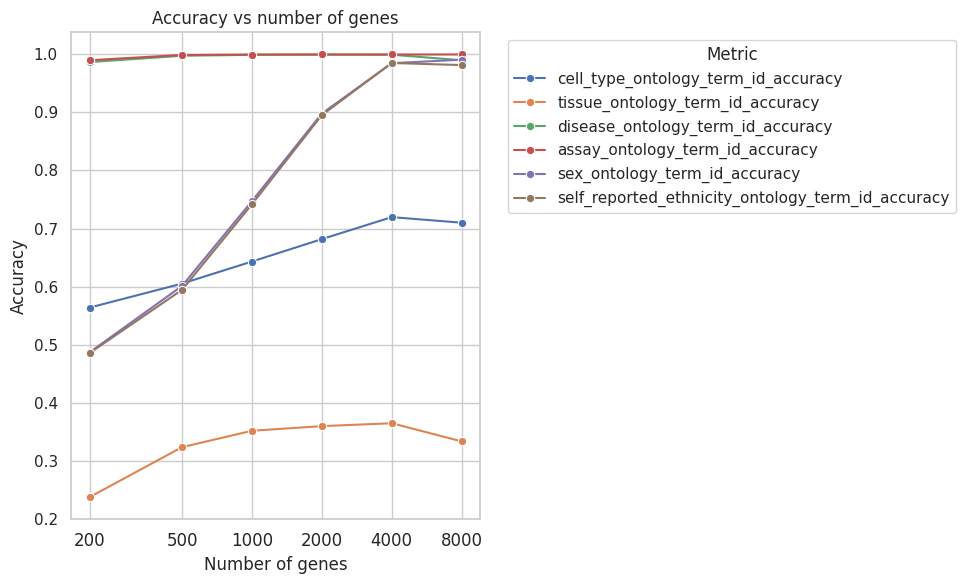

In [15]:
import pandas as pd
import seaborn as sns

metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.5636739392036834,
        "tissue_ontology_term_id_accuracy": 0.23698230800160835,
        "disease_ontology_term_id_accuracy": 0.9868566546039405,
        "assay_ontology_term_id_accuracy": 0.9899979895456373,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.48532368315239244,
        "sex_ontology_term_id_accuracy": 0.4865802171290712,
        "organism_ontology_term_id_accuracy": 0.9740400080418175,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.605033223460472,
        "tissue_ontology_term_id_accuracy": 0.3230548854041013,
        "disease_ontology_term_id_accuracy": 0.9977633695215119,
        "assay_ontology_term_id_accuracy": 0.9991958182549256,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.5942651789304383,
        "sex_ontology_term_id_accuracy": 0.6009499396863691,
        "organism_ontology_term_id_accuracy": 0.9978638922396461,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.6430701616700675,
        "tissue_ontology_term_id_accuracy": 0.3513771612384399,
        "disease_ontology_term_id_accuracy": 0.9993968636911942,
        "assay_ontology_term_id_accuracy": 0.9998743466023321,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.7417320064334539,
        "sex_ontology_term_id_accuracy": 0.7471099718536389,
        "organism_ontology_term_id_accuracy": 0.9999497386409328,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.6816826243917752,
        "tissue_ontology_term_id_accuracy": 0.359343586650583,
        "disease_ontology_term_id_accuracy": 0.9996230398069964,
        "assay_ontology_term_id_accuracy": 1.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.8954061117812626,
        "sex_ontology_term_id_accuracy": 0.8980699638118215,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.7196149217809867,
        "tissue_ontology_term_id_accuracy": 0.36434459187776436,
        "disease_ontology_term_id_accuracy": 0.9996230398069964,
        "assay_ontology_term_id_accuracy": 0.9999497386409328,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9853236831523925,
        "sex_ontology_term_id_accuracy": 0.984996984318456,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.7100141265107518,
        "tissue_ontology_term_id_accuracy": 0.333056895858464,
        "disease_ontology_term_id_accuracy": 0.9899728588661038,
        "assay_ontology_term_id_accuracy": 1.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9817048652995577,
        "sex_ontology_term_id_accuracy": 0.9909529553679132,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
    "sex_ontology_term_id_accuracy",
    "self_reported_ethnicity_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xscale("log")
plt.xlabel("Number of genes")
plt.xticks(df["n_genes"], labels=df["n_genes"], fontsize=12)
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

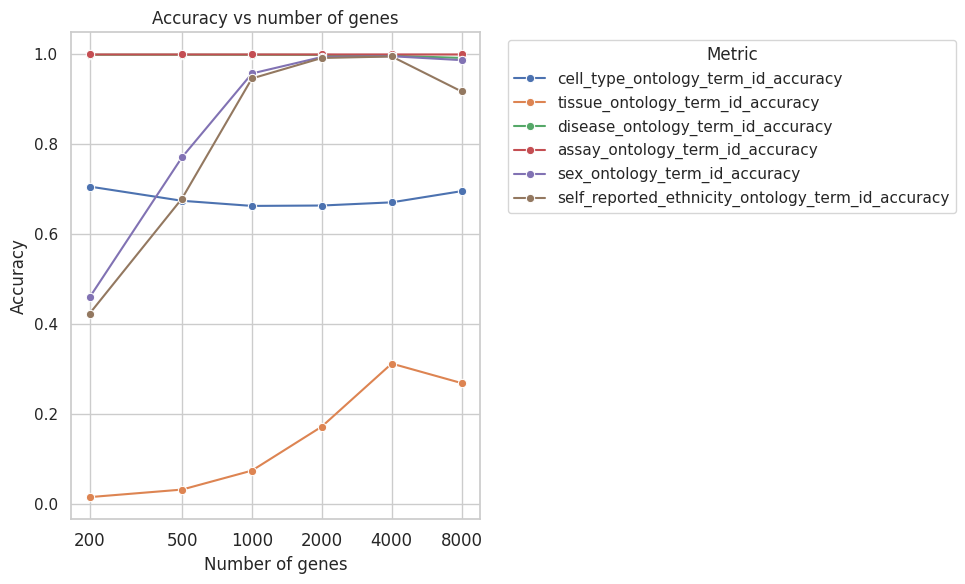

In [16]:
metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.7059592947208706,
        "tissue_ontology_term_id_accuracy": 0.014701447527141134,
        "disease_ontology_term_id_accuracy": 0.9993214716525934,
        "assay_ontology_term_id_accuracy": 0.9999497386409328,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.4231755126658625,
        "sex_ontology_term_id_accuracy": 0.45928829915560915,
        "organism_ontology_term_id_accuracy": 0.9999748693204664,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.674305446554701,
        "tissue_ontology_term_id_accuracy": 0.031463610776035385,
        "disease_ontology_term_id_accuracy": 0.9993717330116606,
        "assay_ontology_term_id_accuracy": 0.9999497386409328,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.6793073984720547,
        "sex_ontology_term_id_accuracy": 0.7711349014877362,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.6628734369277455,
        "tissue_ontology_term_id_accuracy": 0.07375854443104142,
        "disease_ontology_term_id_accuracy": 0.9992460796139928,
        "assay_ontology_term_id_accuracy": 0.9999748693204664,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9465470446320868,
        "sex_ontology_term_id_accuracy": 0.9576548049859268,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.6637367236959137,
        "tissue_ontology_term_id_accuracy": 0.17171793325291515,
        "disease_ontology_term_id_accuracy": 0.9990952955367913,
        "assay_ontology_term_id_accuracy": 0.9999497386409328,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9921592279855247,
        "sex_ontology_term_id_accuracy": 0.9942953357458786,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.6708261392769319,
        "tissue_ontology_term_id_accuracy": 0.31192199437072776,
        "disease_ontology_term_id_accuracy": 0.9972104945717732,
        "assay_ontology_term_id_accuracy": 0.9999748693204664,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9955016083634901,
        "sex_ontology_term_id_accuracy": 0.9960544833132288,
        "organism_ontology_term_id_accuracy": 0.9999748693204664,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.6957568147334275,
        "tissue_ontology_term_id_accuracy": 0.2684710494571773,
        "disease_ontology_term_id_accuracy": 0.9922094893445919,
        "assay_ontology_term_id_accuracy": 0.9999497386409328,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9175713711298753,
        "sex_ontology_term_id_accuracy": 0.9873341375150784,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
    "sex_ontology_term_id_accuracy",
    "self_reported_ethnicity_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xscale("log")
plt.xlabel("Number of genes")
plt.xticks(df["n_genes"], labels=df["n_genes"], fontsize=12)
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# with the novel annotation remapping


In [6]:
embed = Embedder(
    how="random expr",
    max_len=8000,
    num_workers=8,
    pred_embedding=["cell_type_ontology_term_id"],
    doplot=False,
    save_every=10_000,
    keep_all_labels_pred=True,
)
nadata, metrics = embed(model, adata.copy())

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


 20%|██        | 156/773 [01:16<05:05,  2.02it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 19041
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 40%|████      | 313/773 [03:08<03:25,  2.24it/s]  

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 19042
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 61%|██████    | 470/773 [04:55<02:14,  2.25it/s]  

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 18966
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 81%|████████  | 627/773 [06:41<01:05,  2.25it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 18973
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


100%|██████████| 773/773 [08:21<00:00,  1.54it/s]


logging the anndata
AnnData object with n_obs × n_vars = 9225 × 18970
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [7]:
nadata.write(LOC + "glio_smart_cort_area_embedded.h5ad")
del adata

In [8]:
from scprint2.utils.graph_refinement import zero_shot_annotation_with_refinement
from scdataloader.utils import translate
from scprint2.tasks.cell_emb import compute_classification

In [ ]:
# "tissue_ontology_term_id": "UBERON:",
# "organism_ontology_term_id": "NCBIT",
# "assay_ontology_term_id": "EFO:",
# "disease_ontology_term_id": "MONDO:",
# "cell_type_ontology_term_id": "CL:",

In [ ]:
name = "cell_type_ontology_term_id"
code = "CL:"
loc = nadata.obs.columns.str.contains(code)
res = nadata.obs.iloc[:, loc].values.argmax(1)
# res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, loc].values, nadata)
nadata.obs["pred_" + name] = [nadata.obs.columns[loc][i] for i in res]
compute_classification(
    nadata,
    [name],
    model.label_decoders,
    model.labels_hierarchy,
    use_unknown=False,
)

{'cell_type_ontology_term_id': {'accuracy': 0.6866250632484399,
  'macro': 0.45616406177937835,
  'micro': 0.6866250632484399,
  'weighted': 0.6384515076732127}}

In [ ]:
name = "cell_type_ontology_term_id"
code = "CL:"
loc = nadata.obs.columns.str.contains(code)
# res = nadata.obs.iloc[:, loc].values.argmax(1)
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, loc].values, nadata)
nadata.obs["pred_" + name] = [nadata.obs.columns[loc][i] for i in res]
compute_classification(
    nadata,
    [name],
    model.label_decoders,
    model.labels_hierarchy,
    use_unknown=False,
)

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': 0.7068223983808399,
  'macro': 0.4661178930510484,
  'micro': 0.7068223983808399,
  'weighted': 0.6684300138047898}}

In [14]:
compute_classification(
    nadata[(nadata.X > 0).sum(1) >= 8000],
    [name],
    model.label_decoders,
    model.labels_hierarchy,
    use_unknown=False,
)

{'cell_type_ontology_term_id': {'accuracy': 0.760264011634411,
  'macro': 0.42590920716012265,
  'micro': 0.760264011634411,
  'weighted': 0.7476284776455915}}

## testing more stuff


In [27]:
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 1108:1135].values, nadata)
# res = nadata.obs.iloc[:, 1108:1135].values.argmax(1)
nadata.obs["pred_assay_ontology_term_id"] = [
    nadata.obs.columns[1108:1135][i] for i in res
]
compute_classification(
    nadata, ["assay_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# -1% improv

PairwiseArrays with keys: distances, connectivities


{'assay_ontology_term_id': {'accuracy': np.float64(0.9764507989907485),
  'macro': 0.4940425531914894,
  'micro': 0.9764507989907485,
  'weighted': 0.9648164915985183}}

In [ ]:
# res = adata.obs.iloc[:, 783:1090].values.argmax(1)
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 783:1090].values, nadata)
nadata.obs["pred_disease_ontology_term_id"] = [
    nadata.obs.columns[783:1090][i] for i in res
]
compute_classification(
    nadata, ["disease_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# +4% improv

PairwiseArrays with keys: distances, connectivities


{'disease_ontology_term_id': {'accuracy': np.float64(0.7947855340622372),
  'macro': 0.44283036551077787,
  'micro': 0.7947855340622372,
  'weighted': 0.7039103371029185}}

In [ ]:
# res = adata.obs.iloc[:, 783:1090].values.argmax(1)

res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 63:564].values, nadata)
nadata.obs["pred_cell_type_ontology_term_id"] = [
    nadata.obs.columns[63:564][i] for i in res
]
compute_classification(
    nadata, ["cell_type_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# +8% improv!!!

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': np.float64(0.7636669470142977),
  'macro': 0.35765938733124936,
  'micro': 0.7636669470142977,
  'weighted': 0.7360438127690511}}